In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

In [2]:
F=np.array([[3.34638533e-07,  7.58547151e-06, -2.04147752e-03],
   [-5.83765868e-06,  1.36498636e-06, 2.67566877e-04],
   [1.45892349e-03, -4.37648316e-03,  1.00000000e+00]])


In [3]:
img1 = cv.imread(r'Assignment 1 Input Images/Question 2 and 3 Images/000000.png', cv.IMREAD_GRAYSCALE)  # left image
img2 = cv.imread('Assignment 1 Input Images\Question 2 and 3 Images/000023.png', cv.IMREAD_GRAYSCALE)  # right image
 

In [4]:
sift = cv.SIFT_create()
 
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
 

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)
 
flann = cv.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)
 
pts1 = []
pts2 = []

for i,(m,n) in enumerate(matches):
 if m.distance < 0.8*n.distance:
    pts2.append(kp2[m.trainIdx].pt)
    pts1.append(kp1[m.queryIdx].pt)

In [5]:
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F, mask = cv.findFundamentalMat(pts1,pts2,cv.FM_LMEDS)
 
# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

In [6]:
def drawlines(img1,img2,lines,pts1,pts2):
   r,c = img1.shape
   img1 = cv.cvtColor(img1,cv.COLOR_GRAY2BGR)
   img2 = cv.cvtColor(img2,cv.COLOR_GRAY2BGR)
   for r,pt1,pt2 in zip(lines,pts1,pts2):
      color = tuple(np.random.randint(0,255,3).tolist())
      x0,y0 = map(int, [0, -r[2]/r[1] ])
      x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
      img1 = cv.line(img1, (x0,y0), (x1,y1), color,1)
      img1 = cv.circle(img1,tuple(pt1),5,color,-1)
      img2 = cv.circle(img2,tuple(pt2),5,color,-1)
   return img1,img2

In [7]:
def computeCorrespondEpilines(pts, which_image, F):
    if which_image == 1:
        return (l:= np.c_[pts,np.ones(pts.shape[0],dtype=int)]@F.T)/l[:,2].reshape(-1,1)
    elif which_image == 2:
        return (l:= np.c_[pts,np.ones(pts.shape[0],dtype=int)]@F)/l[:,2].reshape(-1,1)


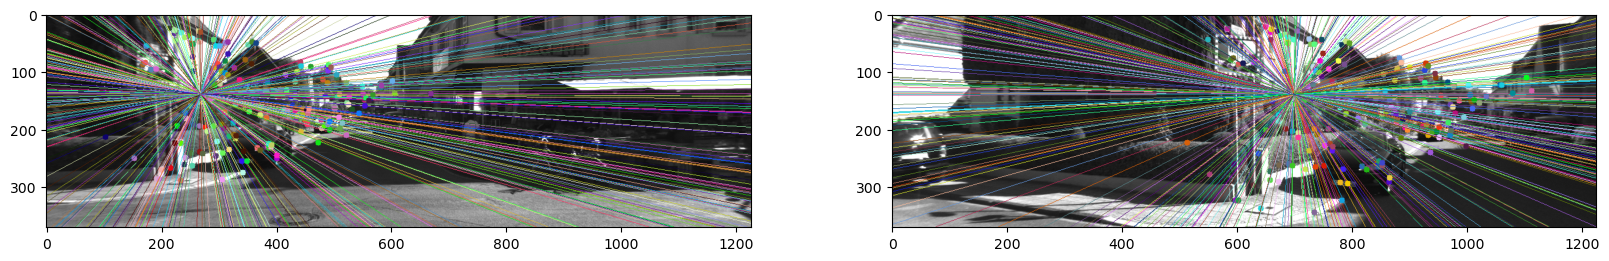

In [16]:
l1 = computeCorrespondEpilines(pts2, 2, F)
l2 = computeCorrespondEpilines(pts1, 1, F)
img9,img10 = drawlines(img1,img2,l1,pts1,pts2)
img7,img8 = drawlines(img2,img1,l2,pts2,pts1)
plt.figure(figsize=(20,50))
plt.subplot(121),plt.imshow(img9)
plt.subplot(122),plt.imshow(img7)
plt.show()

In [9]:
def calc_eqdist_pts(x, y, m, c, d):
    if d == 0:
        return np.c_[x,y]
    x = np.round((np.sqrt(-c**2 + c* (2*y - 2*m * x) + d**2 *(m**2 + 1 ) - (y - m * x)**2) + m *(y - c) + x ) / (1 + m**2)).astype(int)
    y = np.round(m * x + c).astype(int)
    return np.c_[x,y]
calc_eqdist_pts = np.vectorize(calc_eqdist_pts)


In [10]:
def normalized_cross_corr(a, b):
    norm_a = np.linalg.norm(a)
    a = a / norm_a
    norm_b = np.linalg.norm(b)
    b = b / norm_b
    return np.correlate(a.ravel(), b.ravel())

def plot_points(imga,imgb,pts,correspondences,which_image=1):
    plt.figure(figsize=(20,10))
    plt.subplot(121)
    plt.imshow(imga,cmap='gray')
    plt.plot(pts[:,0],pts[:,1],'-ro')
    plt.title(f'Uniform points on Img {which_image}')
    plt.subplot(122)
    plt.imshow(imgb,cmap='gray')
    plt.plot(correspondences[:,0],correspondences[:,1],'ro')
    plt.title(f'Corresponding points on Img {(which_image)%2+1}')
    plt.show()

def find_corresp_pts(select_pt=0, l1=l1,which_image=1, num_pts=11):
    
    if which_image == 1:
        x, y = pts1[select_pt]
        X,Y = pts2[select_pt]
        L = l1
    elif which_image == 2:
        x, y = pts2[select_pt]
        X,Y = pts1[select_pt]
        L = l2
    
    m1 = -L[:,0]/L[:,1]
    C = -L[:,2]/L[:,1]
    m = m1[select_pt]
    c = C[select_pt]
    
    pts = np.r_[[calc_eqdist_pts(x,y,m,c,d=d)[0] for d in np.linspace(0,300,num_pts)]]
    print("Sampled Pts:", pts)
    print("Reference Point:", pts1[select_pt], "Corresponding Point:", pts2[select_pt])

    correspondences = np.zeros_like(pts)
    kernel_size = 5
    pad = kernel_size//2

    l = computeCorrespondEpilines(pts, which_image, F)
    for idx , pt in enumerate(pts):
        template = img1[pt[1]-pad:pt[1]+pad+1,pt[0]-pad:pt[0]+pad+1]
        max_corr = 0
        max_idx = [0,0]
        m = -l[idx,0]/l[idx,1]
        c = -l[idx,2]/l[idx,1]
        # print(l)
        epipolar_line = np.array([[x,np.round(x * m + c).astype(int)] for x in range(img1.shape[1])])
        for i,j in epipolar_line:
            if i < pad or j < pad or i >= img1.shape[1]-pad or j >= img1.shape[0]-pad or i <0 or j< 0 :
                continue
            img_patch = img2[j-pad:j+pad+1,i-pad:i+pad+1]
            corr = normalized_cross_corr(img_patch, template)
            if corr > max_corr:
                max_corr = corr
                max_idx = [i,j]
                # if max_corr > 0.9995:
                #         break
        correspondences[idx] = max_idx

    if which_image == 1:
        plot_points(img1,img2,pts,correspondences,which_image=which_image)
    else:
        plot_points(img2,img1,pts,correspondences,which_image=which_image)
    print("Correspondences:", correspondences)

    return correspondences
    

Sampled Pts: [[182  96]
 [209 108]
 [236 122]
 [263 136]
 [290 149]
 [316 163]
 [343 176]
 [370 190]
 [396 203]
 [423 217]
 [450 231]]
Reference Point: [182  96] Corresponding Point: [602  87]


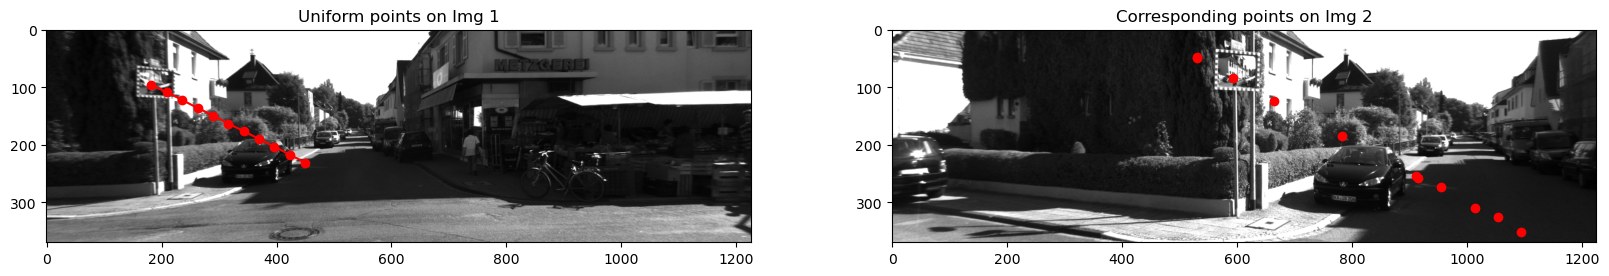

Correspondences: [[ 955  273]
 [ 916  258]
 [ 594   83]
 [ 665  123]
 [1055  325]
 [ 531   47]
 [1094  351]
 [ 783  185]
 [ 531   49]
 [1014  310]
 [ 911  255]]


array([[ 955,  273],
       [ 916,  258],
       [ 594,   83],
       [ 665,  123],
       [1055,  325],
       [ 531,   47],
       [1094,  351],
       [ 783,  185],
       [ 531,   49],
       [1014,  310],
       [ 911,  255]])

In [11]:
# Uniform points from Image 1 and Corresponding points from Image 2
find_corresp_pts(select_pt=8, l1=l1,which_image=1, num_pts=11)

Sampled Pts: [[552 278]
 [573 257]
 [595 237]
 [617 216]
 [639 196]
 [661 175]
 [683 154]
 [705 134]
 [727 113]
 [749  93]
 [771  72]]
Reference Point: [153 250] Corresponding Point: [552 278]


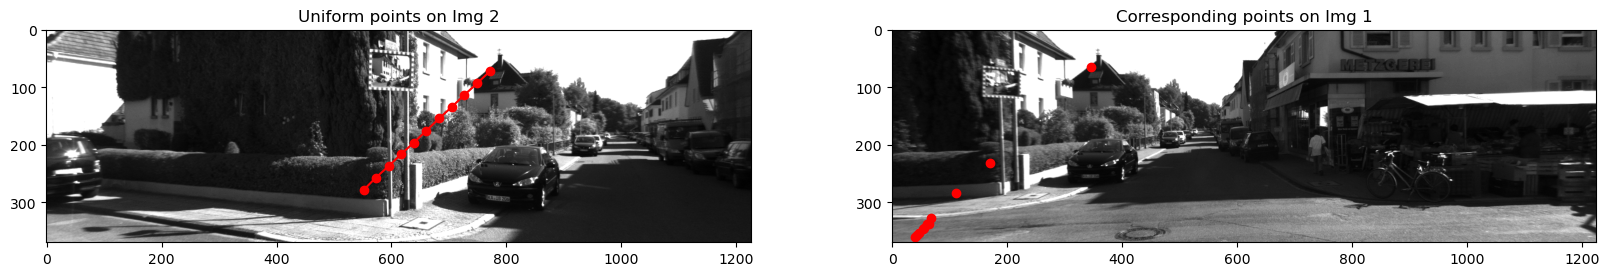

Correspondences: [[ 40 360]
 [ 60 338]
 [ 46 353]
 [346  65]
 [ 43 357]
 [ 53 346]
 [112 284]
 [ 67 328]
 [ 64 338]
 [171 232]
 [ 55 344]]


array([[ 40, 360],
       [ 60, 338],
       [ 46, 353],
       [346,  65],
       [ 43, 357],
       [ 53, 346],
       [112, 284],
       [ 67, 328],
       [ 64, 338],
       [171, 232],
       [ 55, 344]])

In [12]:
# uniform points from Image 2 and their correspondences in Image 1
find_corresp_pts(select_pt=2, l1=l1,which_image=2, num_pts=11)